# Part A: Entertainment

In [2]:
# 1A. Import and read 'images.npy'
import numpy as np
import matplotlib.pyplot as plt

# Load the images.npy file with allow_pickle=True
data = np.load('images.npy', allow_pickle=True)

# Display the shape of the data
print("Data shape:", data.shape)

Data shape: (409, 2)


In [3]:
data[10][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}],
  'imageWidth': 600,
  'imageHeight': 337}]

In [4]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [5]:
# 1B. Split the data into Features (X) and labels (Y) and unify the shape of the images
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [6]:
# 1C. Split the data into train and test sets
X_train = X[:400]
y_train = masks[:400]

X_test = X[400:]
y_test = masks[400:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


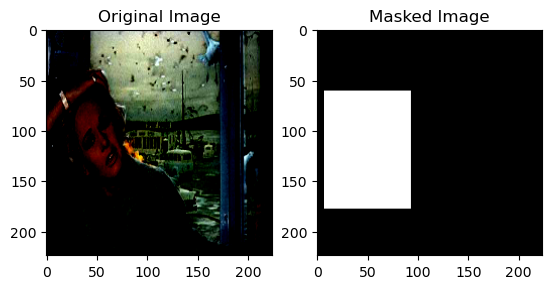

In [7]:
# 1D. Display a random image from the train data along with its masked image
random_index = np.random.randint(0, len(X_train))

# Display original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(X_train[random_index])

# Display masked image
plt.subplot(1, 2, 2)
plt.title("Masked Image")
plt.imshow(y_train[random_index], cmap='gray')
plt.show()

In [8]:
# 2A. Designing the face mask detection model using MobileNet and U-Net architecture
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

# Load MobileNet as the backbone for feature extraction
input_img = Input(shape=(128, 128, 3))
mobilenet = MobileNet(input_tensor=input_img, include_top=False, weights='imagenet')

# Adding U-Net like decoder layers (Upsampling)
up1 = UpSampling2D((2, 2))(mobilenet.output)
conv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)

up2 = UpSampling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)

up3 = UpSampling2D((2, 2))(conv2)
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(up3)

# Final output layer for mask prediction
output = Conv2D(1, (1, 1), activation='sigmoid')(conv3)

# Define the model
model = Model(inputs=input_img, outputs=output)

# Print the model summary
model.summary()

C:\Users\kanak\AppData\Local\Temp\ipykernel_15872\3981353094.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNet(input_tensor=input_img, include_top=False, weights='imagenet')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,500,929 (17.17 MB)

 Trainable params: 4,479,041 (17.09 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [9]:
# 2B. Define Dice Coefficient and Loss function
import tensorflow.keras.backend as K

# Define Dice Coefficient
def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Define Dice Loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [10]:
# 2C. Compile, train, and tune the model
model.compile(loss=dice_loss, optimizer='adam', metrics=[dice_coefficient])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


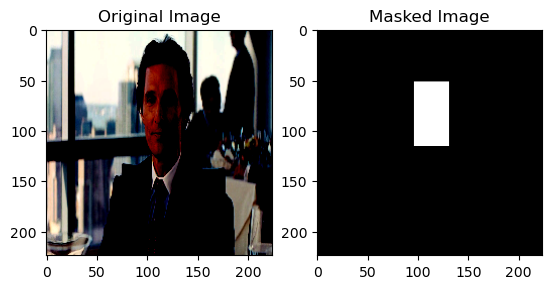

In [11]:
# 3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image
# Display original image
plt.subplot(1, 2, 1)
plt.imshow(X_test[3])
plt.title('Original Image')

# Display corresponding masked image
plt.subplot(1, 2, 2)
plt.imshow(y_test[3], cmap='gray')
plt.title('Masked Image')

plt.show()